# Text classification with Unsloth

This modified Unsloth notebook trains LLaMa-3 on any text classification dataset, where the input is a csv with columns "text" and "label".

### Added features:

- Trims the classification head to contain only the "Yes" and "No" tokens, which saves 1 GB of VRAM, allows you to train the head without massive memory usage, and makes the start of the training session more stable.
- Only the last token in the sequence contributes to the loss, the model doesn't waste its capacity by trying to predict the input
- includes "group_by_length = True" which speeds up training significantly for unbalanced sequence lengths
- Efficiently evaluates the accuracy on the validation set using batched inference


In [1]:
# needed as this function doesn't like it when the lm_head has its size changed
from unsloth import tokenizer_utils
def do_nothing(*args, **kwargs):
    pass
tokenizer_utils.fix_untrained_tokens = do_nothing

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [2]:
import torch
major_version, minor_version = torch.cuda.get_device_capability()
print(f"Major: {major_version}, Minor: {minor_version}")
from datasets import load_dataset
import datasets
from trl import SFTTrainer
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments, Trainer
from typing import Tuple
import warnings
from typing import Any, Dict, List, Union
from transformers import DataCollatorForLanguageModeling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# os.environ["WANDB_DISABLED"] = "true"

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+


# model_name = "unsloth/Qwen2-7B-bnb-4bit";load_in_4bit = True
model_name = "unsloth/llama-3-8b-bnb-4bit";load_in_4bit = True,

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,load_in_4bit = load_in_4bit,
    max_seq_length = max_seq_length,
    dtype = dtype,
)

Major: 8, Minor: 6
==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.43.3.
   \\   /|    GPU: NVIDIA GeForce RTX 3090. Max memory: 23.999 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.6. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.26.post1. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


We now trim the classification head

In [3]:
yes_token_id = tokenizer.encode("Yes", add_special_tokens=False)[0]
no_token_id = tokenizer.encode("No", add_special_tokens=False)[0]
# keep only the yes and no tokens from lm_head
par = torch.nn.Parameter(torch.vstack([model.lm_head.weight[no_token_id, :], model.lm_head.weight[yes_token_id, :]]))
print(par.shape)
print(model.lm_head.weight.shape)
model.lm_head.weight = par

torch.Size([2, 4096])
torch.Size([128256, 4096])


In [4]:
from peft import LoftQConfig

model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = [
        "lm_head", # can easily be trained because it has only 2 tokens
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = True,  # We support rank stabilized LoRA
    # init_lora_weights = 'loftq',
    # loftq_config = LoftQConfig(loftq_bits = 4, loftq_iter = 1), # And LoftQ
)
print("trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Unsloth: Offloading output_embeddings to disk to save VRAM


Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Unsloth: Casting lm_head to float32
trainable parameters: 41951232


In [5]:
kaggle = os.getcwd() == "/kaggle/working"
input_dir = "/kaggle/input/whatever/" if kaggle else "data/"
output_dir = "/kaggle/working/" if kaggle else "data/"
data = pd.read_csv(input_dir + "finance_sentiment.csv") # columns are text,label

train_size = 1000
val_size = 1000

# keep a subset (for testing)
data_sample = data.sample(n=train_size+val_size, random_state=42)


train_df, val_df = train_test_split(data_sample, test_size=val_size/len(data_sample), random_state=42)
print(len(train_df))

1000


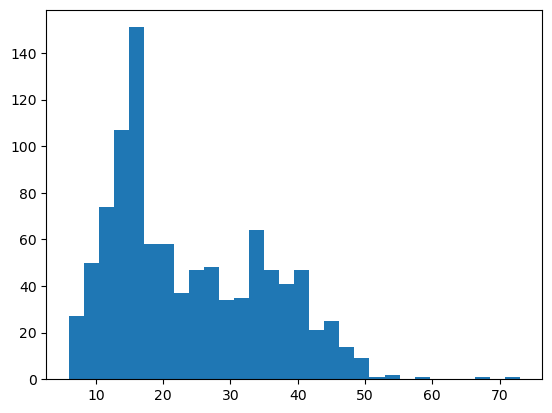

In [6]:
token_counts = [len(tokenizer.encode(x)) for x in train_df.text]
# plot the token counts
a = plt.hist(token_counts, bins=30)

In [7]:
train_dataset = datasets.Dataset.from_pandas(train_df,preserve_index=False)
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

In [8]:
prompt = """Here is a financial tweet:
{}

Does this tweet have a positive sentiment? Answer with "Yes" or "No".

SOLUTION
The correct answer is: "{}"""

positivelabel = "Yes"
negativelabel = "No"

# if you are doing classification with more than 2 classes, you can setup a prompt like this and change the head trimming part:
# Here is a text:
# {text}

# Classify it into one of the following:
# class 1: a book
# class 2: a poem
# class 3: a manual

# The correct answer is: class x

def formatting_prompts_func(dataset_):
    # this is to fix an issue with the transformers library where the first time this function is called, it is called with a string for some reason
    if isinstance(dataset_['text'], str):
        return [" "]*100
        
    texts = []
    for i in range(len(dataset_['text'])):
        t = dataset_['text'][i]
        label = positivelabel if dataset_['label'][i] == 1 else negativelabel
        text = prompt.format(t, label)


        texts.append(text)
    return texts

In [9]:
# this custom collator is needed to change the sequence labels from yes_token_id and no_token_id to 1 and 0. It also trains only on the last token of the sequence.
class DataCollatorForLastTokenLM(DataCollatorForLanguageModeling):
    def __init__(
        self,
        *args,
        mlm: bool = False,
        ignore_index: int = -100,
        **kwargs,
    ):
        super().__init__(*args, mlm=mlm, **kwargs)
        self.ignore_index = ignore_index

    def torch_call(self, examples: List[Union[List[int], Any, Dict[str, Any]]]) -> Dict[str, Any]:
        batch = super().torch_call(examples)

        for i in range(len(examples)):
            # Find the last non-padding token
            last_token_idx = (batch["labels"][i] != self.ignore_index).nonzero()[-1].item()
            # Set all labels to ignore_index except for the last token
            batch["labels"][i, :last_token_idx] = self.ignore_index
            # The old labels for the Yes and No tokens need to be mapped to 1 and 0
            batch["labels"][i, last_token_idx] = 1 if batch["labels"][i, last_token_idx] == yes_token_id else 0


        return batch
collator = DataCollatorForLastTokenLM(tokenizer=tokenizer)

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [ ]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # not needed because group_by_length is True
    args = TrainingArguments(
        per_device_train_batch_size = 32,
        gradient_accumulation_steps = 1,
        warmup_steps = 10,
        learning_rate = 1e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        num_train_epochs = 1,
        # report_to = "wandb",
        report_to = "none",
        group_by_length = True,
    ),
    formatting_func=formatting_prompts_func,
    data_collator=collator,
)

In [11]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 3090. Max memory = 23.999 GB.
5.457 GB of memory reserved.


In [12]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 32 | Gradient Accumulation steps = 1
\        /    Total batch size = 32 | Total steps = 32
 "-____-"     Number of trainable parameters = 41,951,232


Step,Training Loss
1,0.605800
2,0.633300
3,0.615600
4,0.552300
5,0.375500
6,0.357400
7,0.115400
8,0.582600
9,0.270600
10,0.131400


In [13]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

109.7726 seconds used for training.
1.83 minutes used for training.
Peak reserved memory = 5.666 GB.
Peak reserved memory for training = 0.209 GB.
Peak reserved memory % of max memory = 23.609 %.
Peak reserved memory for training % of max memory = 0.871 %.


<a name="Inference"></a>
### Inference
This part evaluates the model on the val set with batched inference

In [14]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

In [15]:
saved_name = f"lora_model_{model_name.replace('/','_')}"
model.save_pretrained(saved_name)

In [16]:
from collections import defaultdict
import torch.nn.functional as F

# Step 1: Tokenize the inputs and sort them by their tokenized length
tokenized_inputs = []
for i in range(len(val_df['text'])):
    text = val_df['text'].iloc[i]
    test_str = prompt.format(text, "")
    tokenized_input = tokenizer(test_str, return_tensors="pt", add_special_tokens=False)
    tokenized_inputs.append((tokenized_input, test_str, val_df['label'].iloc[i]))

# Sort by tokenized length
tokenized_inputs.sort(key=lambda x: x[0]['input_ids'].shape[1])

# Step 2: Group the inputs by their tokenized length
grouped_inputs = defaultdict(list)
for tokenized_input, test_str, label in tokenized_inputs:
    length = tokenized_input['input_ids'].shape[1]
    grouped_inputs[length].append((tokenized_input, test_str, label))

# Step 3: Process each group in batches of 64
batch_size = 64
all_outputs = []
all_strings = []
all_labels = []

from tqdm import tqdm
for length, group in tqdm(grouped_inputs.items()):
    for i in range(0, len(group), batch_size):
        batch = group[i:i+batch_size]
        batch_inputs = [item[0] for item in batch]
        batch_strings = [item[1] for item in batch]
        batch_labels = [item[2] for item in batch]

        # Concatenate the batch inputs
        input_ids = torch.cat([item['input_ids'] for item in batch_inputs], dim=0).to("cuda")
        attention_mask = torch.cat([item['attention_mask'] for item in batch_inputs], dim=0).to("cuda")

        # Forward pass
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # print(outputs.logits[:, -1].shape)
        
        # logits are shape (batch_size, sequence_length, num_classes), we want only the last token of each sequence in the batch
        logits = outputs.logits[:, -1, :]
        
        # Apply softmax
        probabilities = F.softmax(logits, dim=-1)
        
        # Get predictions
        predictions = torch.argmax(probabilities, dim=-1)
        
        all_outputs.extend(predictions.cpu().numpy())
        all_labels.extend(batch_labels)
        all_strings.extend(batch_strings)

# Step 4: Do the label assignment
correct = 0
total = 0

for i in range(len(all_outputs)):
    pred = str(all_outputs[i])
    label = str(all_labels[i])
    if i > len(all_outputs) - 25:
        print(f"{i}: text: {all_strings[i]}\n pred: {pred} label: {label}\n")

    if pred == label:
        correct += 1
    total += 1

print(f"Correct: {correct} Total: {total} Accuracy: {correct/total}")

100%|██████████| 52/52 [00:32<00:00,  1.62it/s]

976: text: Here is a financial tweet:
Pound falls as Boris Johnson taken to intensive care for COVID-19 https://t.co/5JQIgSSH7P by @OscarWGrut https://t.co/7h0RrKnKHK

Does this tweet have a positive sentiment? Answer with "Yes" or "No".

SOLUTION
The correct answer is: "
 pred: 0 label: 0

977: text: Here is a financial tweet:
Stocks are plummeting. Fortunately for you, @JimCramer is here to break it all down: https://t.co/1mWoCg5j3S https://t.co/vzGsLact9Z

Does this tweet have a positive sentiment? Answer with "Yes" or "No".

SOLUTION
The correct answer is: "
 pred: 0 label: 0

978: text: Here is a financial tweet:
$BGR - BlackRock Energy & Resources Trust: Buy This 8.3% Yielding CEF For Upside In Oil. Read more and get updates… https://t.co/ucVW2s05J1

Does this tweet have a positive sentiment? Answer with "Yes" or "No".

SOLUTION
The correct answer is: "
 pred: 1 label: 1

979: text: Here is a financial tweet:
U.S. Stocks Open Higher as Risk Appetite Improves #SP500 #index #Market

In [ ]:
# stop running all cells
1/0

Now if you stopped the notebook kernel and want to load the LoRA adapters, you need this monkeypatch to avoid a size mismatch issue:

In [18]:
import torch
from torch.nn import Module
from collections import OrderedDict
from typing import Mapping, Any, List, NamedTuple

from unsloth import tokenizer_utils
def do_nothing(*args, **kwargs):
    pass
tokenizer_utils.fix_untrained_tokens = do_nothing

from datasets import load_dataset
import datasets
from trl import SFTTrainer
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments, Trainer
from typing import Tuple
import warnings
from typing import Any, Dict, List, Union
from transformers import DataCollatorForLanguageModeling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import Qwen2ForCausalLM, Qwen2Tokenizer



def _find_mismatched_keys(
    model: torch.nn.Module, peft_model_state_dict: dict[str, torch.Tensor], ignore_mismatched_sizes: bool = True
) -> tuple[dict[str, torch.Tensor], list[tuple[str, tuple[int, ...], tuple[int, ...]]]]:
    return peft_model_state_dict, []

# Monkey patch the original function
import peft.utils.save_and_load
peft.utils.save_and_load._find_mismatched_keys = _find_mismatched_keys




class _IncompatibleKeys(NamedTuple):
    missing_keys: List[str]
    unexpected_keys: List[str]

def patched_load_state_dict(self, state_dict: Mapping[str, Any], strict: bool = True, assign: bool = False):
    if not isinstance(state_dict, Mapping):
        raise TypeError(f"Expected state_dict to be dict-like, got {type(state_dict)}.")

    missing_keys: List[str] = []
    unexpected_keys: List[str] = []
    error_msgs: List[str] = []

    # copy state_dict so _load_from_state_dict can modify it
    metadata = getattr(state_dict, "_metadata", None)
    state_dict = OrderedDict(state_dict)
    if metadata is not None:
        state_dict._metadata = metadata  # type: ignore[attr-defined]

    def load(module, local_state_dict, prefix=""):
        local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
        if assign:
            local_metadata["assign_to_params_buffers"] = assign
        module._load_from_state_dict(
            local_state_dict,
            prefix,
            local_metadata,
            True,
            missing_keys,
            unexpected_keys,
            error_msgs,
        )
        for name, child in module._modules.items():
            if child is not None:
                child_prefix = prefix + name + "."
                child_state_dict = {k: v for k, v in local_state_dict.items() if k.startswith(child_prefix)}
                load(child, child_state_dict, child_prefix)

        incompatible_keys = _IncompatibleKeys(missing_keys, unexpected_keys)
        for hook in module._load_state_dict_post_hooks.values():
            out = hook(module, incompatible_keys)
            assert out is None, (
                "Hooks registered with ``register_load_state_dict_post_hook`` are not"
                "expected to return new values, if incompatible_keys need to be modified,"
                "it should be done inplace."
            )

    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict, missing_keys, unexpected_keys, error_msgs):
        for name, param in self._parameters.items():
            key = prefix + name
            if key in state_dict:
                input_param = state_dict[key]
                if param.shape != input_param.shape:
                    print(f"Shape mismatch for {key}, creating new tensor. Old shape: {param.shape}, New shape: {input_param.shape}")
                    # Create a new parameter with the shape from state_dict
                    new_param = torch.nn.Parameter(torch.empty_like(input_param), requires_grad=param.requires_grad)
                    new_param.data.copy_(input_param)
                    setattr(self, name, new_param)
                else:
                    param.data.copy_(input_param)
            elif strict:
                missing_keys.append(key)

        for name, buf in self._buffers.items():
            key = prefix + name
            if key in state_dict:
                input_buf = state_dict[key]
                if buf.shape != input_buf.shape:
                    print(f"Shape mismatch for buffer {key}, creating new tensor. Old shape: {buf.shape}, New shape: {input_buf.shape}")
                    # Create a new buffer with the shape from state_dict
                    new_buf = torch.empty_like(input_buf)
                    new_buf.copy_(input_buf)
                    setattr(self, name, new_buf)
                else:
                    buf.copy_(input_buf)
            elif strict:
                missing_keys.append(key)

    # Monkey patch the _load_from_state_dict method
    Module._load_from_state_dict = _load_from_state_dict

    load(self, state_dict)
    del load

    if strict:
        if len(unexpected_keys) > 0:
            error_msgs.insert(0, "Unexpected key(s) in state_dict: {}. ".format(", ".join(f'"{k}"' for k in unexpected_keys)))
        if len(missing_keys) > 0:
            error_msgs.insert(0, "Missing key(s) in state_dict: {}. ".format(", ".join(f'"{k}"' for k in missing_keys)))

    if len(error_msgs) > 0:
        raise RuntimeError("Error(s) in loading state_dict for {}:\n\t{}".format(self.__class__.__name__, "\n\t".join(error_msgs)))
    
    return _IncompatibleKeys(missing_keys, unexpected_keys)

# Apply the monkey patch
Module.load_state_dict = patched_load_state_dict




# Load model
model, tokenizer = FastLanguageModel.from_pretrained(saved_name)

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [19]:
# Merge to 16bit
if False: model.save_pretrained_merged("hf/model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("hf/model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

In [20]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in `llama.cpp` or a UI based system like `GPT4All`. You can install GPT4All by going [here](https://gpt4all.io/index.html).

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Zephyr DPO 2x faster [free Colab](https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Llama 7b [free Kaggle](https://www.kaggle.com/danielhanchen/unsloth-alpaca-t4-ddp)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Support our work if you can! Thanks!
</div>